In [1]:
import ROOT
import math
# Colors
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from root_numpy import root2array, tree2array
from root_numpy import testdata, fill_hist
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (recall_score,  precision_score, f1_score, roc_auc_score, precision_recall_curve,
                             make_scorer, confusion_matrix, accuracy_score, roc_curve)
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

Welcome to JupyROOT 6.14/04


Using TensorFlow backend.


## Previous Analysis

Checking amount of signal and background events in all of the configurations formed by region, tag and signal type.

#### Add new column with signal label

In [2]:
# If the row sample is 'Xtohh1000' or 'Xtohh2000', then the new columns will have a 1 in this row.
def classifier(row):
    if row['sample'] == 'Xtohh1000':
        return 1
    #else if row['sample'] == 'Xtohh2000':
    #    return 1
    else:
        return 0

In [3]:
# Select rows different of data samples
# Select rows on the SR_1tag region
def sel_df(df, region):
    df = df[(df['sample']!='data') & (df['m_region']==region)]
    df["signal"] = df.apply(classifier, axis=1)
    return df

In [4]:
def print_configs():
    print('%-15s%-10s%-10s%-10s%-10s' % ("Region", "Xtohh", "Signal", "Bkg", "Data"))
    for sig in [1000,2000]:
        rfile = ROOT.TFile("/home/andrea/Escritorio/CERN data/Try3/all_"+str(sig)+".root")
        intree = rfile.Get("Nominal")
        array = tree2array(intree)
        df = pd.DataFrame(array)
        for reg in np.unique(df['m_region'].values):
            df2 = df[(df['sample']=='data') & (df['m_region']==reg)]
            data = df2['sample'].value_counts().values[0]
            df_aux = sel_df(df, reg)
            bkg = df_aux["signal"].value_counts(sort=False).values[0]
            signal = df_aux["signal"].value_counts(sort=False).values[1]
            print('%-15s%-10i%-10i%-10i%-10i' % (reg, sig, signal, bkg, data))
    return

##### Run once

In [35]:
print_configs()

Region         Xtohh     Signal    Bkg       Data      
PreSel_0tag    1000      2550      98061     713       
PreSel_1tag    1000      4681      16467     130       
PreSel_2tag    1000      4343      995       6         
QCDCR_0tag     1000      557       38603     279       
QCDCR_1tag     1000      1128      7205      49        
QCDCR_2tag     1000      1166      556       5         
SR_0tag        1000      1993      59458     434       
SR_1tag        1000      3553      9262      81        
SR_2tag        1000      3177      439       1         
PreSel_0tag    2000      2867      98061     713       
PreSel_1tag    2000      11507     16467     130       
PreSel_2tag    2000      13720     995       6         
QCDCR_0tag     2000      544       38603     279       
QCDCR_1tag     2000      2152      7205      49        
QCDCR_2tag     2000      2271      556       5         
SR_0tag        2000      2323      59458     434       
SR_1tag        2000      9355      9262      81 

## Import ROOT file

You can either import a file which includes both Xtohh1000 and Xtohh2000 signal events, but their samples must be different or import just the file which includes one of the signals and the background.

In [5]:
rfile = ROOT.TFile("/home/andrea/Escritorio/CERN data/Try3/all_1000.root")
intree = rfile.Get("Nominal")
array = tree2array(intree)
df = pd.DataFrame(array)
df = sel_df(df, "SR_1tag")

# Delete columns
not_cons = ['sample', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']
df.drop(not_cons, axis=1, inplace=True)

## Dividing data for training and testing

In [6]:
# Features
feature_cols = df.columns.values[:-1]

X = df.loc[:, feature_cols].values
# Targets
y = df['signal'].values

#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X, y)

from imblearn.over_sampling import SMOTE, ADASYN
#https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)


print("Training size:",X_train.shape[0])
print("Test size:", X_test.shape[0])
values, counts = np.unique(y, return_counts=True)
print("Signal amount:", counts[1],",", round(counts[1]/y.shape[0], 2),"%")
print("Background amount:", counts[0],",", round(counts[0]/y.shape[0], 2),"%")

Training size: 14804
Test size: 2563
Signal amount: 3553 , 0.28 %
Background amount: 9262 , 0.72 %


In [7]:
values_s, count_s = np.unique(y_train, return_counts=True)
print("Signal training events:", count_s[1],",", round(count_s[1]/X_train.shape[0], 2),"%")
print("Background training events:", count_s[0],",", round(count_s[0]/X_train.shape[0],2),"%")
values_b, count_b = np.unique(y_test, return_counts=True)
print("Signal testing events:", count_b[1],",", round(count_b[1]/X_test.shape[0],2),"%")
print("Background testing events:", count_b[0],",", round(count_b[0]/X_test.shape[0],2),"%")

Signal training events: 7402 , 0.5 %
Background training events: 7402 , 0.5 %
Signal testing events: 703 , 0.27 %
Background testing events: 1860 , 0.73 %


## Custom metric: F1

In [8]:
def f1_(y_true, y_pred):
    def recall_(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Configure neural network

In [10]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform', input_dim=11))
classifier.add(Dropout(rate= 0.1))
#Second  Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Third  Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Fourth Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Fifth Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))

In [11]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =[f1_])

In [12]:
#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=50, epochs=200)

Epoch 1/200
14804/14804 [==============================] - 3s 226us/step - loss: 0.6679 - f1_: 0.6562
Epoch 2/200
14804/14804 [==============================] - 2s 121us/step - loss: 0.6392 - f1_: 0.6869
Epoch 3/200
14804/14804 [==============================] - 2s 103us/step - loss: 0.6349 - f1_: 0.6885
Epoch 4/200
14804/14804 [==============================] - 2s 103us/step - loss: 0.6136 - f1_: 0.6924
Epoch 5/200
14804/14804 [==============================] - 2s 104us/step - loss: 0.5937 - f1_: 0.7044
Epoch 6/200
14804/14804 [==============================] - 2s 106us/step - loss: 0.5674 - f1_: 0.7304
Epoch 7/200
14804/14804 [==============================] - 2s 120us/step - loss: 0.5732 - f1_: 0.7269
Epoch 8/200
14804/14804 [==============================] - 2s 110us/step - loss: 0.5677 - f1_: 0.7340
Epoch 9/200
14804/14804 [==============================] - 2s 114us/step - loss: 0.5534 - f1_: 0.7342
Epoch 10/200
14804/14804 [==============================] - 2s 112us/step - loss: 

14804/14804 [==============================] - 3s 196us/step - loss: 0.5261 - f1_: 0.7586
Epoch 81/200
14804/14804 [==============================] - 4s 282us/step - loss: 0.5287 - f1_: 0.7552
Epoch 82/200
14804/14804 [==============================] - 3s 225us/step - loss: 0.5329 - f1_: 0.7564
Epoch 83/200
14804/14804 [==============================] - 2s 169us/step - loss: 0.5231 - f1_: 0.7658
Epoch 84/200
14804/14804 [==============================] - 3s 197us/step - loss: 0.5317 - f1_: 0.7560
Epoch 85/200
14804/14804 [==============================] - 3s 169us/step - loss: 0.5254 - f1_: 0.7639
Epoch 86/200
14804/14804 [==============================] - 2s 149us/step - loss: 0.5504 - f1_: 0.7392
Epoch 87/200
14804/14804 [==============================] - 3s 179us/step - loss: 0.5480 - f1_: 0.7321
Epoch 88/200
14804/14804 [==============================] - 3s 177us/step - loss: 0.5325 - f1_: 0.7550
Epoch 89/200
14804/14804 [==============================] - 2s 146us/step - loss: 0.55

14804/14804 [==============================] - 2s 119us/step - loss: 0.5312 - f1_: 0.7567
Epoch 160/200
14804/14804 [==============================] - 2s 130us/step - loss: 0.5211 - f1_: 0.7693
Epoch 161/200
14804/14804 [==============================] - 2s 130us/step - loss: 0.5264 - f1_: 0.7706
Epoch 162/200
14804/14804 [==============================] - 2s 113us/step - loss: 0.5146 - f1_: 0.7726
Epoch 163/200
14804/14804 [==============================] - 2s 115us/step - loss: 0.5190 - f1_: 0.7693
Epoch 164/200
14804/14804 [==============================] - 2s 126us/step - loss: 0.5077 - f1_: 0.7740
Epoch 165/200
14804/14804 [==============================] - 2s 129us/step - loss: 0.5072 - f1_: 0.7740
Epoch 166/200
14804/14804 [==============================] - 2s 119us/step - loss: 0.5115 - f1_: 0.7701
Epoch 167/200
14804/14804 [==============================] - 2s 115us/step - loss: 0.5017 - f1_: 0.7804
Epoch 168/200
14804/14804 [==============================] - 2s 119us/step - l

0.8181185854785176

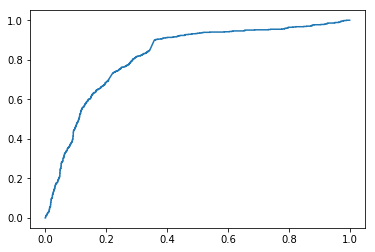

In [13]:
y_pred_prob = classifier.predict(X_test)
y_pred = (y_pred_prob>0.5)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
plt.plot(fpr, tpr)
roc_auc_score(y_test, y_pred_prob)


In [14]:
r = recall_score(y_test,y_pred)
p = precision_score(y_test,y_pred)
a = accuracy_score(y_test,y_pred)

print("recall:", r)
print("precision:", p)
print("accuracy:", a)

recall: 0.9231863442389758
precision: 0.43703703703703706
accuracy: 0.6527506827936013


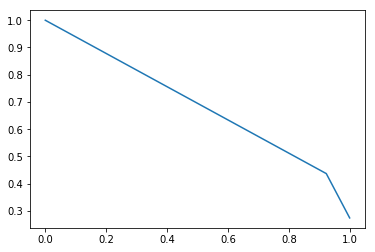

In [15]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)

In [16]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1024  836]
 [  54  649]]


In [17]:
y_test[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [18]:
y_pred[:20]
aux = np.concatenate(y_pred[:20])
1*aux

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1])

## TO DO:

- Ver método de oversampling debido al desbalanceo de los datos. Un método típico es el SMOTE.
- Hacer una tabla resumen de las configuraciones de región y señal, para generar los modelos de entrenamiento, contar la cantidad de señal y background en cada configuración.
- Usar f1 de HER2 como métrica de entrenamiento.